In [23]:
from pathlib import Path
import pickle
import torch 
import numpy as np
import matplotlib.pyplot as plt
import alu_dataset
import model_evaluation

# Upload Forcasts calculated by CoSTA and DDM models

In [3]:

# ------- Load estimates----------------
# #-------------------DDM models-----------------------------------------
filename = Path("COSTA", "DDM", "Forecasts", "X_est_plainDense100.pickle")
with open(filename, "rb") as handle:
    X_est_plainDense = pickle.load(handle)

filename = Path("COSTA", "DDM", "Forecasts", "X_est_plainSparse100.pickle")
with open(filename, "rb") as handle:
    X_est_plainSparse = pickle.load(handle)


##------------------CoSTA models--------------------------------------------------
filename = Path("COSTA", "corr_NN", "Forecasts", "X_est_plainDense_COSTA100.pickle")
with open(filename, "rb") as handle:
    X_est_COSTA_plainDense = pickle.load(handle)

filename = Path("COSTA", "corr_NN", "Forecasts", "X_est_plainSparse_COSTA100.pickle")
with open(filename, "rb") as handle:
    X_est_COSTA_plainSparse = pickle.load(handle)


# Upload training-set, make dataset object

In [26]:
with open('COSTA_data/dSet.pickle', 'rb') as handle:
    traindata = pickle.load(handle)

In [27]:
# Trained on different dataset sizes
#10*5000,  20*5000 and 40*5000
# In paper, only 40*5000 included
DT = 10
dSetSize = [10,20,40]

DATASETS = []
for i in range(len(dSetSize)):
    DATASETS.append(alu_dataset.Dataset_alu(traindata[0:dSetSize[i],:,:],DT))


# Upload testset

In [28]:
with open('COSTA_data/testSet100.pickle', 'rb') as handle:
    testset = pickle.load(handle)

with open('COSTA_data/testSet100V_cell.pickle', 'rb') as handle:
    V_cell = pickle.load(handle)

with open('COSTA_data/testSet100T_liq.pickle', 'rb') as handle:
    T_liq = pickle.load(handle)

# Generate data for ablated PBM

In [29]:
import ablated_pbm

RK4_PBM, Volt_Tliq_pbm_fun, f_pbm = ablated_pbm.ablated_PBM_RK4()


In [30]:
X_est_PBM = ablated_pbm.RollingForecast_pbm(test=testset, RK4 =RK4_PBM, DT=10)

In [87]:
Volt_Tliq_pbm_est = ablated_pbm.Voltage_liquidus_temp_pbm(X_pbm_RF=X_est_PBM,volt_T_liq_pbm=Volt_Tliq_pbm_fun)

torch.Size([5000, 13])


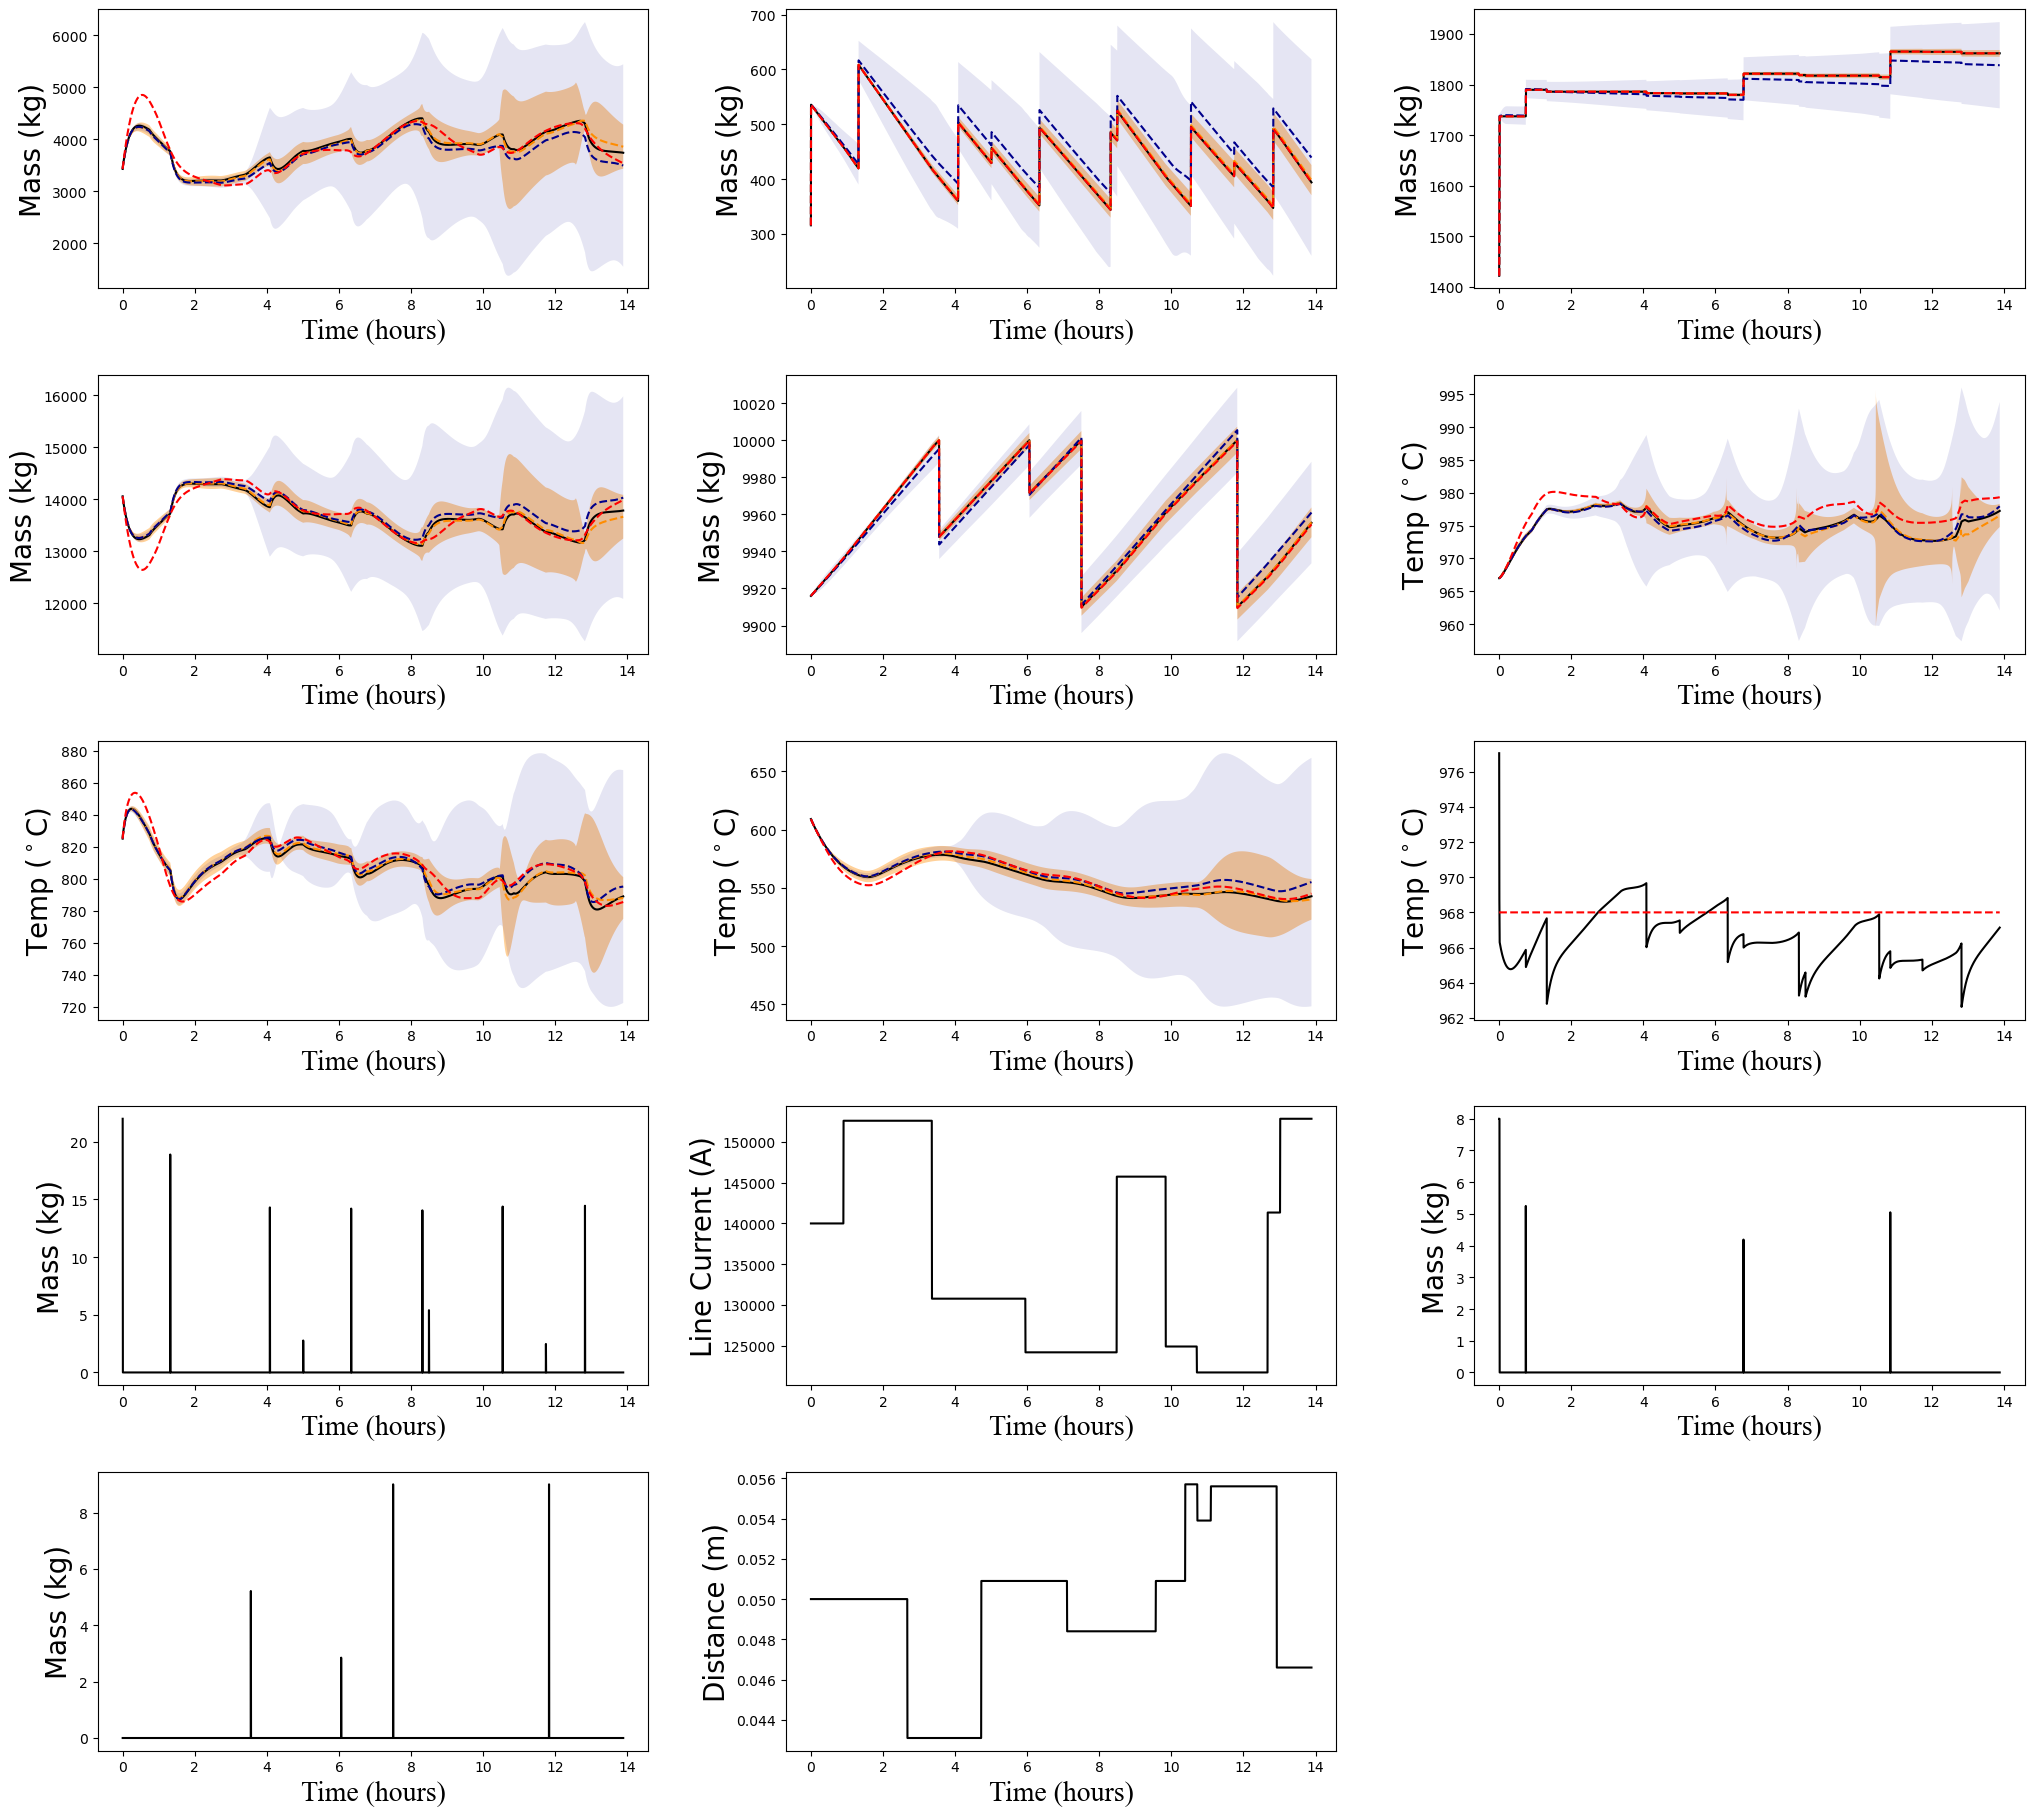

In [94]:


fig_trajectory_forecasts = model_evaluation.testset_estimate_trajectory(testset, X_est_costa=X_est_COSTA_plainSparse, X_est_DDM=X_est_plainSparse, X_est_PBM=X_est_PBM,\
                                Tliq=T_liq, Volt_Tliq_pbm=Volt_Tliq_pbm_est, sim_num=80, dSet_no=2, start_ind=0, end_ind=5000, DT=10)

# Average Normalized Rolling Forecast Mean Squared Error (AN-RFMSE) values

In [109]:
hor = np.array([0,100, 2500, 5000])
no_of_horizons = len(hor)-1
dSet = 2
RFMSE_multi_horizon, Divergence_multi_horizon = model_evaluation.lists_of_RFMSE_val(testset=testset, hor=hor,no_of_horizons=no_of_horizons,X_est_costa_dense=X_est_COSTA_plainDense,\
                                                                    X_est_costa_sparse=X_est_COSTA_plainSparse,X_est_DDM_dense=X_est_plainDense,\
                                                                    X_est_DDM_sparse=X_est_plainSparse,DATASETS=DATASETS, X_est_PBM=X_est_PBM,dset_no=2)

# AN-RFMSE violin plot for multiple horizons

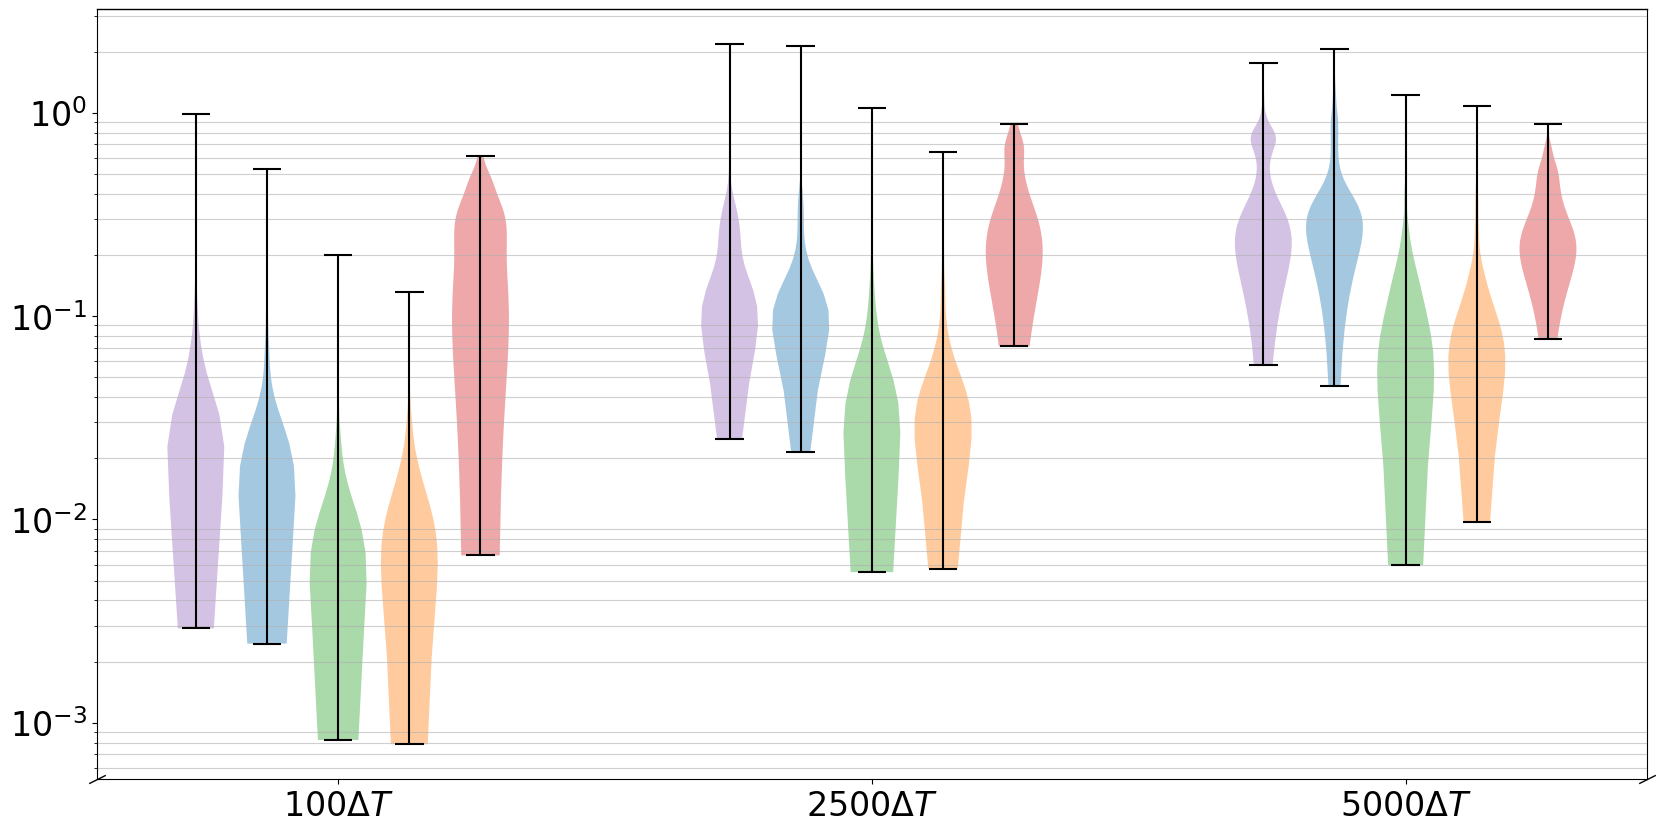

In [110]:
horizons = [100, 2500, 5000]
fig_violin = model_evaluation.RFMSE_violin_multi_horizon_plot(RFMSE_multi_horizon, horizons, log=True)

# Divergence plots for multiple horizons

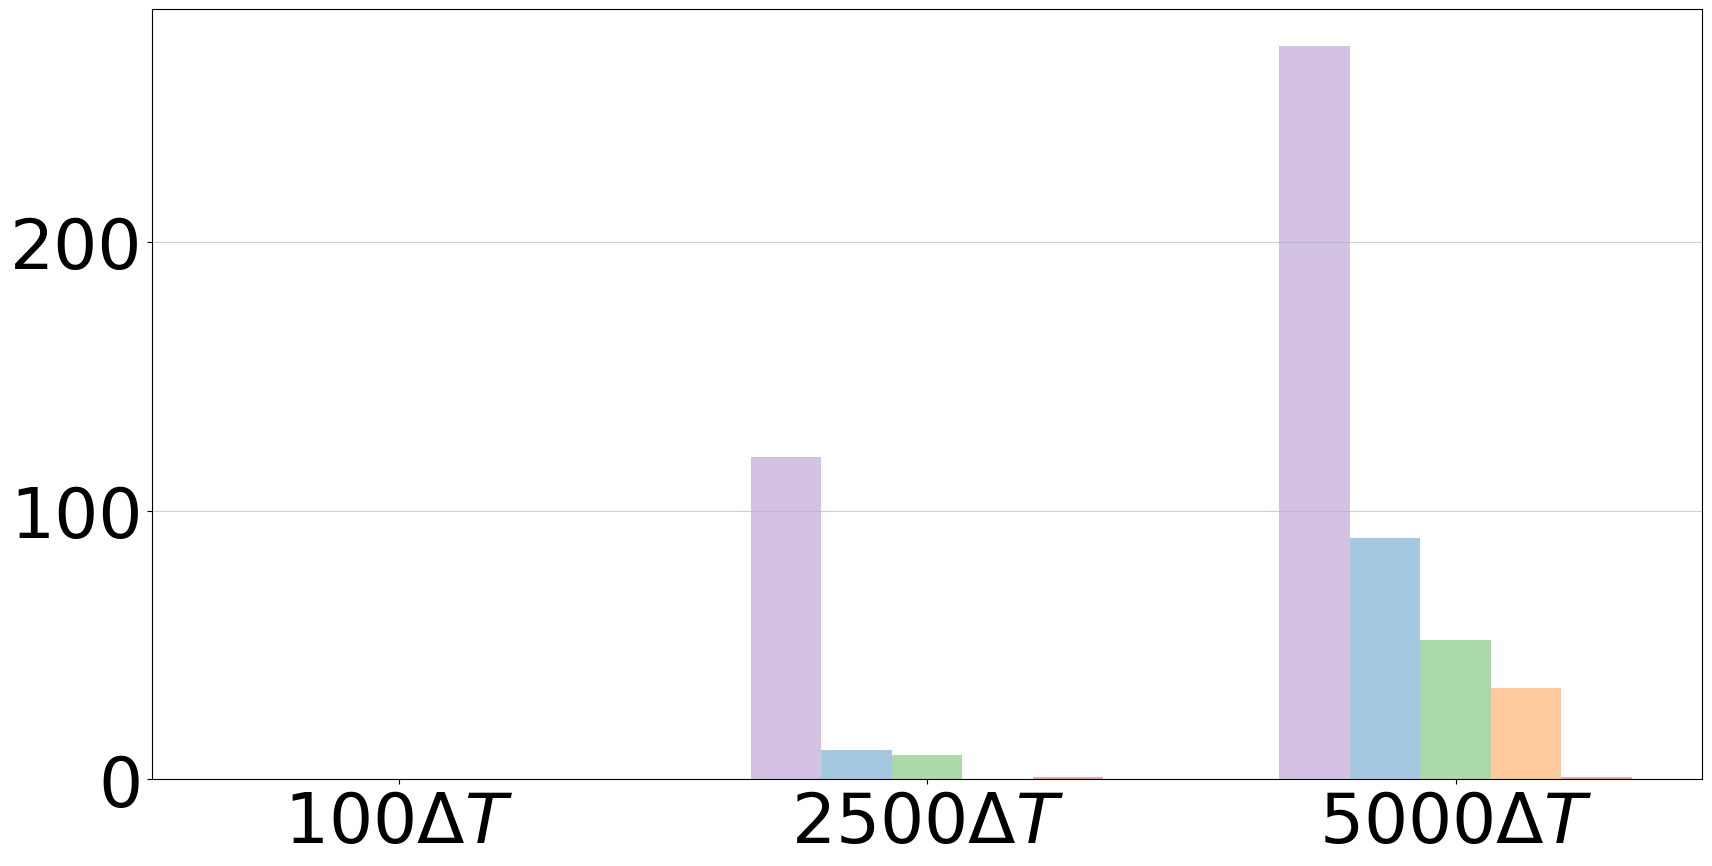

In [111]:
fig_divergence = model_evaluation.divergence_plot_multi_horizons(Divergence_multi_horizon, horizons,labelsize=50)